In [210]:
from urllib.request import urlopen
import json
import re
from urllib.parse import quote
import pandas as pd
from pandas.io.json import json_normalize
import collections
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2
import numpy as np
# conda install -c phlya adjusttext 
#from adjustText import adjust_text

In [227]:
###### Get data #####
n = 2500

# Initial query - get most active wikis
query = "http://www.wikia.com/api/v1/Wikis/List?expand=1&limit="+str(n)+"&batch=1"
response = urlopen(query)
wikisource = response.read()
data = json.loads(wikisource)
df = pd.DataFrame(data['items'])
fullDataSet = df
 
# Search for more wikis (primarily based on the different hub names)
def searchForWiki(search, n):
    querySearch = "http://www.wikia.com/api/v1/Wikis/ByString?expand=1&string="+str(search)+"&limit="+str(n)+"&batch=1&includeDomain=true"
    response = urlopen(querySearch)
    data = json.loads(response.read())
    return pd.DataFrame(data['items']) 
    
# use hubs in dataset to searsh for new wikis
for hub in set(df["hub"]):
    df2 = searchForWiki(hub, n)
    fullDataSet = fullDataSet.append(df2)
    print("%s wikis found in %s" % (str(len(df2)), hub))
fullDataSet

30 wikis found in Lifestyle
250 wikis found in Other
250 wikis found in Movies
250 wikis found in Music
250 wikis found in Comics
250 wikis found in Books
250 wikis found in TV
250 wikis found in Games


,creation_date,desc,domain,flags,founding_user_id,headline,hub,id,image,lang,language,name,original_dimensions,stats,title,topUsers,topic,url,wam_score,wordmark
0,2013-02-14 11:25:40,"""Old School RuneScape"" is Jagex's official ter...",oldschoolrunescape.wikia.com,[],1649337,Welcome to the Old School RuneScape Wiki,Games,691244,https://images.wikia.nocookie.net/__cb20170706...,en,en,Old School RuneScape Wiki,"{'width': 480, 'height': 320}","{'edits': 7425610, 'articles': 19813, 'pages':...",Old School RuneScape Wiki,"[3044102, 1759647, 4097547, 26578522, 8306, 50...",Gaming,http://oldschoolrunescape.wikia.com,95.5018,https://vignette.wikia.nocookie.net/2007scape/...
1,2005-02-07 06:40:52,Created and maintained by the Fallout communit...,fallout.wikia.com,[],0,Nukapedia - The Fallout Wiki,Games,3035,https://images.wikia.nocookie.net/__cb20170307...,en,en,Fallout Wiki,"{'width': 1751, 'height': 1337}","{'edits': 2925242, 'articles': 27381, 'pages':...",Fallout Wiki,"[3183960, 27868532, 3076045, 31775388, 4286974...",Gaming,http://fallout.wikia.com,99.7960,https://vignette.wikia.nocookie.net/fallout/im...
2,2009-06-16 17:10:14,Red Dead Wiki is a community-built site about ...,reddead.wikia.com,[],131372,Welcome to the Red Dead Wiki!,Games,30404,https://images.wikia.nocookie.net/__cb20161102...,en,en,Red Dead Wiki,"{'width': 480, 'height': 360}","{'edits': 334118, 'articles': 2621, 'pages': 8...",Red Dead Wiki,"[1376364, 28191207, 4090850, 33558234, 2735137...",Gaming,http://reddead.wikia.com,99.4347,https://vignette.wikia.nocookie.net/reddeadred...
3,2006-03-29 02:45:59,"The Elder Scrolls Wiki consists of over 60,000...",elderscrolls.wikia.com,[],0,The Elder Scrolls Wiki,Games,1706,https://images.wikia.nocookie.net/__cb20170307...,en,en,Elder Scrolls,"{'width': 1800, 'height': 1565}","{'edits': 2776470, 'articles': 61679, 'pages':...",Elder Scrolls,"[32045548, 25356303, 17401442, 30169600, 26074...",Gaming,http://elderscrolls.wikia.com,99.5703,https://vignette4.wikia.nocookie.net/elderscro...
4,2005-05-26 11:44:29,Yu-Gi-Oh! Wikia is a database on Konami's Yu-G...,yugioh.wikia.com,[],310,Yu-Gi-Oh! Wikia,Games,410,https://images.wikia.nocookie.net/__cb20161102...,en,en,Yu-Gi-Oh!,"{'width': 320, 'height': 320}","{'edits': 3993815, 'articles': 108240, 'pages'...",Yu-Gi-Oh!,"[3040170, 4129195, 3545725, 5452442, 3564254, ...",Anime,http://yugioh.wikia.com,99.4536,https://img3.wikia.nocookie.net/__cb2014041821...
5,2004-11-11 23:33:14,Wookieepedia is an online encyclopedia that co...,starwars.wikia.com,[],2041,"Wookieepedia, the Star Wars Wiki",Movies,147,https://images.wikia.nocookie.net/__cb20061211...,en,en,Wookieepedia,"{'width': 1042, 'height': 1042}","{'edits': 7941654, 'articles': 145786, 'pages'...",Wookieepedia,"[24962224, 27768064, 24165583, 7090787, 309238...",Entertainment,http://starwars.wikia.com,99.7613,https://img3.wikia.nocookie.net/__cb2015010101...
6,2012-06-01 18:53:17,Warframe Wiki is a player supported encycloped...,warframe.fandom.com,[],5156670,Discover the mysteries of the Tenno.,Games,544934,https://images.wikia.nocookie.net/__cb20161102...,en,en,WARFRAME Wiki,"{'width': 1920, 'height': 1145}","{'edits': 1845700, 'articles': 4566, 'pages': ...",WARFRAME Wiki,"[25254386, 34103815, 14475, 26061294, 15339176...",Gaming,https://warframe.fandom.com,99.7302,https://vignette4.wikia.nocookie.net/warframe/...
7,2005-04-08 07:30:06,"Started in April of 2005, the RuneScape Wiki's...",runescape.fandom.com,[],2648,The RuneScape Wiki,Games,304,https://images.wikia.nocookie.net/__cb20181004...,en,en,RuneScape Wiki,"{'width': 192, 'height': 192}","{'edits': 23434134, 'articles': 43969, 'pages'...",RuneScape Wiki,"[3044102, 19402885, 32232648, 9852177, 3373504...",Gaming,https://runescape.fandom.com,90.7248,https://vignette.wikia.nocookie.net/runescape2...
8,2005-07-04 03:57:32,Harry Potter Wiki is a collaborative knowledge...,harrypotter.wikia.com,[],3676,Harry Potter Wiki,Books,509,https://images.wikia.nocookie.net/__cb20170

In [220]:
# remove inactive wikis and duplicates
def findActiveWikis(dataSet):
    activeDataSet = pd.DataFrame()
    #i = 0
    # find stats in dataset
    for s in dataSet['stats']:
        data = dataSet.loc[dataSet['stats']==s]
        # only add when at least 1 active
        if s['activeUsers']>1:
            activeDataSet = activeDataSet.append(data)
            #i +=s['activeUsers']
    # remove duplicates
    activeDataSet = activeDataSet.drop_duplicates(subset="id")
    activeDataSet = activeDataSet.reset_index(drop=True)
    return activeDataSet#, i

In [221]:
# search online to find the username based on the userID
def findUsernames(userID):
    querySearch = "http://community.wikia.com/wiki/Special:Search?search="+userID+"&fulltext=Search&ns2=1"
    response = urlopen(querySearch)
    wikisource = response.read()
    usernames = set(re.findall("User:(\w+)?",str(wikisource)))
    return usernames

In [222]:
# search online to find the wikis which the user use, 
# though his resent activity found though username
def findWikisThroughUser(usernames):
    wikis = []
    for username in usernames:
        querySearch = "http://community.wikia.com/index.php?limit=1000&tagfilter=&title=Special%3AContributions&target="+username+"&namespace=&tagfilter=&year=&month=-1"
        response = urlopen(querySearch)
        wikisource = response.read()
        wikis.append(set(re.findall("Adoption:(\w+)?",str(wikisource))))
    return wikis

In [223]:
# When a connection to a wiki is found, the user is added to 'topUsers' in the dataframe
def addUserToWiki(wiki,userID, dataSet):
    series = dataSet.loc[dataSet['name'] == wiki]
    topUsers = list(series['topUsers'].values)
    topUsers = list(itertools.chain.from_iterable(topUsers))
    if userID not in topUsers:
        topUsers.append(int(userID))
        dataSet.at[series.index.values[0], "topUsers"] = set(topUsers)
    return dataSet

In [224]:
# print/caculate the number of wiki's which the user is connected to
def printUserInWiki(userID, dataSet):
    i = 0
    j = 0
    for users in list(dataSet['topUsers'].values):
        if int(userID) in list(users):
            i+=1
        else:
            j+=1
    #print("%s user found in %s wikis, not in %s wikis" % (userID,i,j))  
    return i

In [225]:
# adding the users (and wikis, if new are discovered) to the dataframe
def addWikis(userID, dataSet, userfound, wikifound):
    username = findUsernames(userID)
    
    if len(list(username))==0:
        userfound[0]+= 1
        return dataSet, userfound, wikifound
    
    wikiList = findWikisThroughUser(username)
    
    if len(wikiList) == 0:
        userfound[1]+= 1
        return dataSet, userfound, wikifound
    else:
        userfound[2]+= 1
        
    i = printUserInWiki(userID, dataSet)
    
    # the data is listed nested
    for wikis in list(wikiList):
        for wiki in set(list(wikis)):
            wiki = wiki.replace("_", " ")
            # If wiki already exsists in the dataset, the user is assed
            if wiki in list(dataSet['name']):
                wikifound[0]+=1
                #print("%s found in Dataset" % wiki)
                dataSet = addUserToWiki(wiki,userID, dataSet)
            # if the wiki does not exsist, a search for it is made.
            else:
                wiki = wiki.replace(" ", "_")
                wikidf = searchForWiki(wiki, 250)
                # wikidf = findActiveWikis(wikidf)
                dataSet = dataSet.append(wikidf)
                dataSet = dataSet.reset_index(drop=True)
                wikifound[1]+= len(wikidf)
                wiki = wiki.replace("_", " ")
                if wiki in dataSet['name']:
                    dataSet = addUserToWiki(wiki,userID, dataSet)
                    wikifound[2]+=1
                    print("wiki %s added to Dataset and user added" % wiki)
                #else:
                    #print("--- %s not found in Dataset" % wiki)
    
    #j = printUserInWiki(userID, fullDataSet)
    #print("User added to %s new wikis" % j-i)
    return dataSet, userfound, wikifound

In [ ]:
# Get active wikis
activeDataSet = findActiveWikis(fullDataSet)
print("full data set has %s data, while only %s is actively used." % (len(fullDataSet),len(activeDataSet)))
print()
# Find more users and their connected Wikis
userfound = [0,0,0]
wikifound = [0,0,0]

# find topusers
#topUsers = []
topUsers = [x for x in activeDataSet["topUsers"]]
founders = [x for x in activeDataSet['founding_user_id']]
topUsers.append(founders)
topUsers = list(itertools.chain.from_iterable(topUsers))
for i in range(len(topUsers)):
    activeDataSet, userfound, wikifound = addWikis(str(topUsers[i]), activeDataSet, userfound, wikifound)
    activeDataSet = findActiveWikis(activeDataSet)
    if(i%25==0):
        print("%s af %s, wikicount= %s" % (str(i),str(len(topUsers)),str(len(activeDataSet))), end="\n - ")
        print("UsersNotFound: %s, wikisNotFound: %s, infoFound: %s" % (userfound[0],userfound[1], userfound[2]), end="\n - ")
        print("UsersAddedToWiki: %s, newWikisFound: %s, usersAddedToNewWikis: %s" % (wikifound[0],wikifound[1],wikifound[2]))


full data set has 2030 data, while only 262 is actively used.

0 af 2304, wikicount= 262
 - UsersNotFound: 1, wikisNotFound: 0, infoFound: 0
 - UsersAddedToWiki: 0, newWikisFound: 0, usersAddedToNewWikis: 0
25 af 2304, wikicount= 262
 - UsersNotFound: 26, wikisNotFound: 0, infoFound: 0
 - UsersAddedToWiki: 0, newWikisFound: 0, usersAddedToNewWikis: 0


In [ ]:
topUsers = [x for x in activeDataSet["topUsers"]]
topUsers = list(itertools.chain.from_iterable(topUsers))

counter=collections.Counter(topUsers)
#print(counter)
#print(counter.values())
#print(counter.keys())
print(counter.most_common(7))

print(len(topUsers))

In [10]:
# Make graph
G = nx.Graph()

# add nodes
for wiki in activeDataSet["name"]:
    G.add_node(wiki, hub=set(activeDataSet['hub'].loc[activeDataSet['name'] ==wiki].values))

5896


In [11]:
# find the wiki names of the users
users = {}
for user in counter.most_common():
    user = user[0]
    for k, v in activeDataSet.T.items():
        if user in v["topUsers"]:
            if user not in users:
                users[user] = []
            users[user].append(v['name'])

In [ ]:
# create edges between all wikis which share users
def createEdges(G,userWikis):
    length = len(userWikis)
    if length==1:
        return G
    elif length>1:
        wiki = userWikis.pop()
        for w in userWikis:
            if G.has_edge(wiki, w):
                G[wiki][w]['weight']+=1
            else:
                G.add_edge(wiki,w,weight=1)
        return createEdges(G,userWikis)
    else:
        return G

In [12]:
# iterate over all users
for k,v in users.items():
    #print(set(v))
    G = createEdges(G,set(v))

In [13]:
# Set layout
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1,

                          # Performance
                          jitterTolerance=0.5,  #1 # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=0.01, #0.01
                          strongGravityMode=False, #False
                          gravity=30, #15

                          # Log
                          verbose=True)


# Calculate Positions
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

100%|██████████| 2000/2000 [00:18<00:00, 110.16it/s]

BarnesHut Approximation  took  5.56  seconds
Repulsion forces  took  10.26  seconds
Gravitational forces  took  0.15  seconds
Attraction forces  took  0.47  seconds
AdjustSpeedAndApplyForces step  took  0.67  seconds


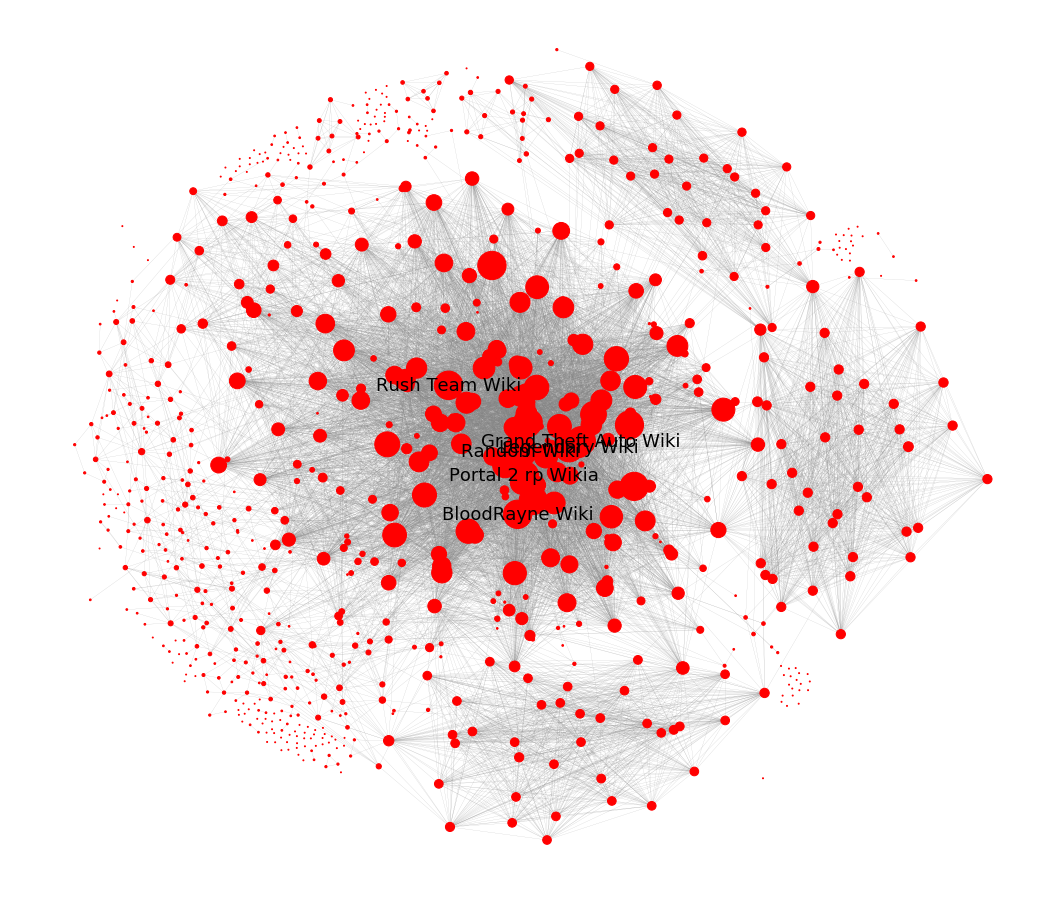

In [15]:
# plot figure
plt.figure(figsize=(18, 16))             
node_size = [(G.degree(node, weight='weight')*2)+1 for node in G.nodes()]  

labels = {}    
for node in G.nodes():
    if G.degree(node, weight='weight')*2 > 800:
        #set the node name as the key and the label as its value 
        labels[node] = node

node_label = [node for node in G.nodes() ]
nx.draw_networkx_nodes(G, positions, nodelist=G.nodes, node_size=node_size,cmap=plt.get_cmap('jet'))
nx.draw_networkx_edges(G, positions, width=0.1, cmap=plt.get_cmap('jet'), edge_color="gray")
nx.draw_networkx_labels(G, positions, labels=labels, font_size=18, font_color='k', font_weight='normal', alpha=2.0)
#texts = [plt.text(n, labels[n], ha='center', va='center') for n in G.nodes()]
#adjust_text(texts)#, only_move='y', arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
plt.axis('off')
plt.savefig('wikiNetwork.png')
plt.show()

In [16]:
len(G.edges())

9965

In [17]:
len(G.nodes())

815

In [176]:
# Find degrees according to hub
hubsDegree = {}
maxDegree = 0
for i in range(len(G.nodes)): 
    n = list(G.nodes)[i]
    nodehubs = list(G.node[n]['hub'])
    degree = G.degree(n)#, weight='weight')
    for hub in nodehubs:
        if hub not in hubsDegree:
            hubsDegree[hub] = []
        hubsDegree[hub].append(degree)
    if degree>maxDegree:
        maxDegree = degree

for k, degree in hubsDegree.items():
    print(k, max(degree))

Games 122
Movies 95
Books 110
TV 116
Comics 99
Lifestyle 127
Other 167
Music 125


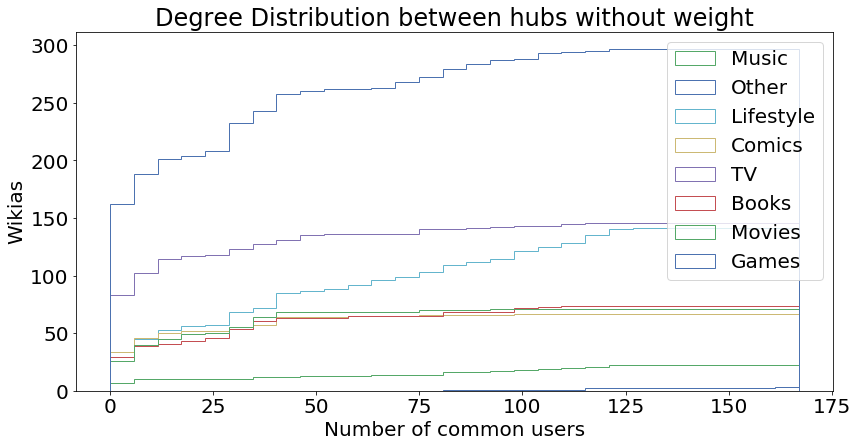

In [177]:
# Create Cumulative Step Histogram 
plt.figure(figsize=(12, 6))  
plt.style.use('seaborn-deep')
bins = np.linspace(0, maxDegree, 30)

plt.hist(list(hubsDegree.values()), 
         bins, 
         label=list(hubsDegree.keys()), 
         histtype='step', 
         cumulative=True)
#patch.linewidth

plt.legend(loc='upper right')
plt.tight_layout()
plt.title("Degree Distribution between hubs without weight")
plt.ylabel("Wikias")
plt.xlabel("Number of common users")
plt.savefig('wikiDegreeCumulativeHist.png')
plt.show()

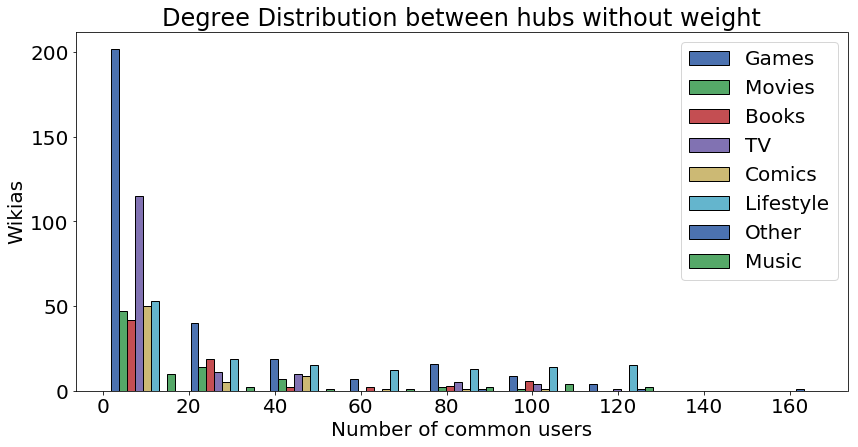

In [178]:
# Create Bin Histogram 
plt.figure(figsize=(12, 6))  
plt.style.use('seaborn-deep')
bins = np.linspace(0, maxDegree, 10)

plt.hist(list(hubsDegree.values()), 
         bins, 
         label=list(hubsDegree.keys()), 
         histtype='bar',
         edgecolor='black')

plt.legend(loc='upper right')
plt.tight_layout()
plt.title("Degree Distribution between hubs without weight")
plt.ylabel("Wikias")
plt.xlabel("Number of common users")
plt.savefig('wikiDegreeHist.png')
plt.show()

[(0, 148), (1, 96), (2, 57)]


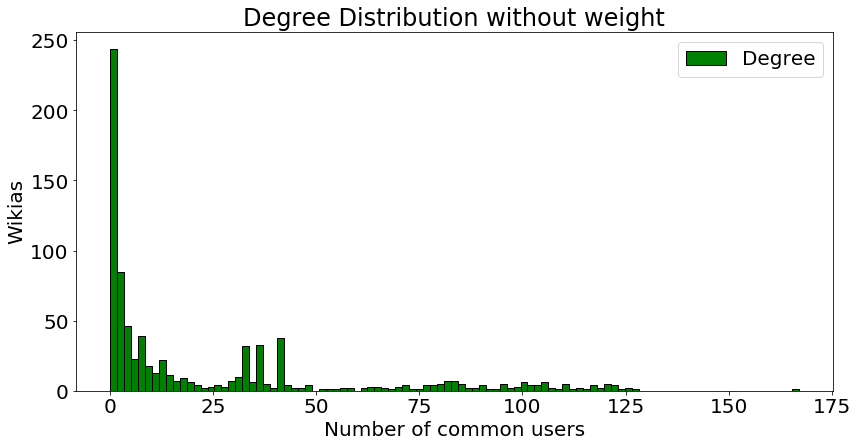

In [179]:
plt.rcParams.update({'font.size': 20})
degrees = [val for (node, val) in G.degree()]
cnt = collections.Counter(degrees)
print(cnt.most_common(3))
# Create Bin Histogram 
plt.figure(figsize=(12, 6))  
plt.style.use('seaborn-deep')
bins = np.linspace(0, max(degrees), 100)

plt.hist(degrees, 
         bins, 
         label="Degree", 
         histtype='bar',
         color='Green',
         edgecolor='black')

plt.legend(loc='upper right')
plt.tight_layout()
plt.title("Degree Distribution without weight")
plt.ylabel("Wikias")
plt.xlabel("Number of common users")
plt.savefig('wikiDegreeSumHist.png')
plt.show()

[(2, 57), (42, 36), (33, 32)]


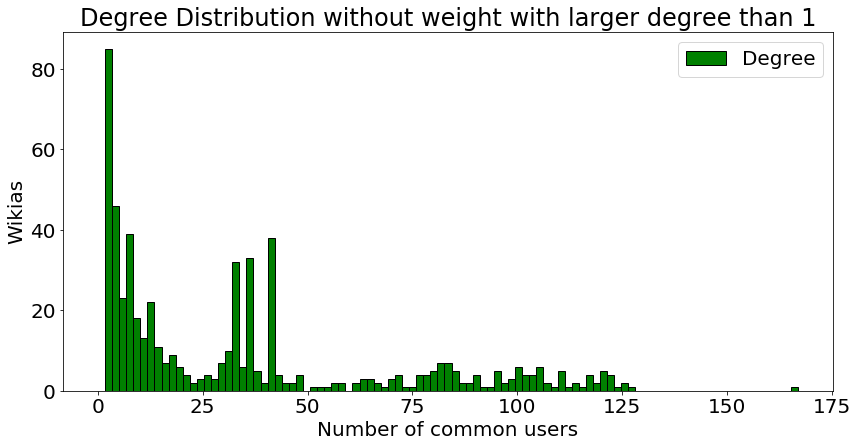

In [180]:
plt.rcParams.update({'font.size': 20})
degrees = [val for (node, val) in G.degree() if val>1]
cnt = collections.Counter(degrees)
print(cnt.most_common(3))
# Create Bin Histogram 
plt.figure(figsize=(12, 6))  
plt.style.use('seaborn-deep')
bins = np.linspace(0, max(degrees), 100)

plt.hist(degrees, 
         bins, 
         label="Degree", 
         histtype='bar',
         color='Green',
         edgecolor='black')

plt.legend(loc='upper right')
plt.tight_layout()
plt.title("Degree Distribution without weight with larger degree than 1")
plt.ylabel("Wikias")
plt.xlabel("Number of common users")
plt.savefig('wikiDegreelarger1SumHist.png')
plt.show()

[(42, 36), (33, 32), (37, 31)]


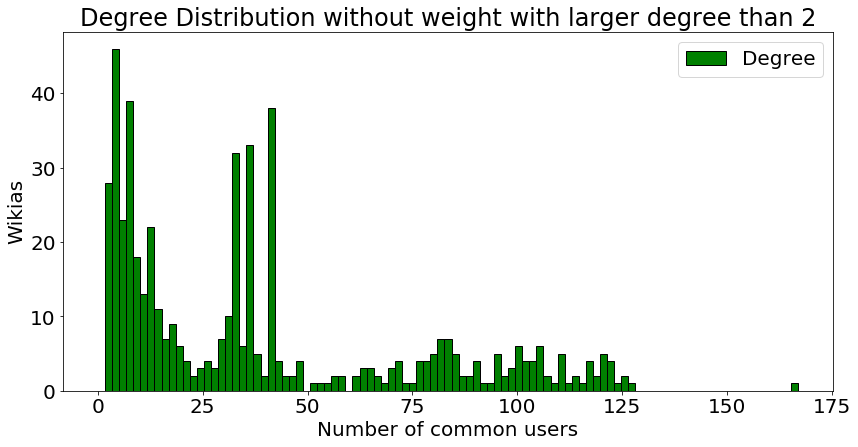

In [181]:
plt.rcParams.update({'font.size': 20})
degrees = [val for (node, val) in G.degree() if val>2]
cnt = collections.Counter(degrees)
print(cnt.most_common(3))
# Create Bin Histogram 
plt.figure(figsize=(12, 6))  
plt.style.use('seaborn-deep')
bins = np.linspace(0, max(degrees), 100)

plt.hist(degrees, 
         bins, 
         label="Degree", 
         histtype='bar',
         color='Green',
         edgecolor='black')

plt.legend(loc='upper right')
plt.tight_layout()
plt.title("Degree Distribution without weight with larger degree than 2")
plt.ylabel("Wikias")
plt.xlabel("Number of common users")
plt.savefig('wikiDegreelarger2Hist.png')
plt.show()

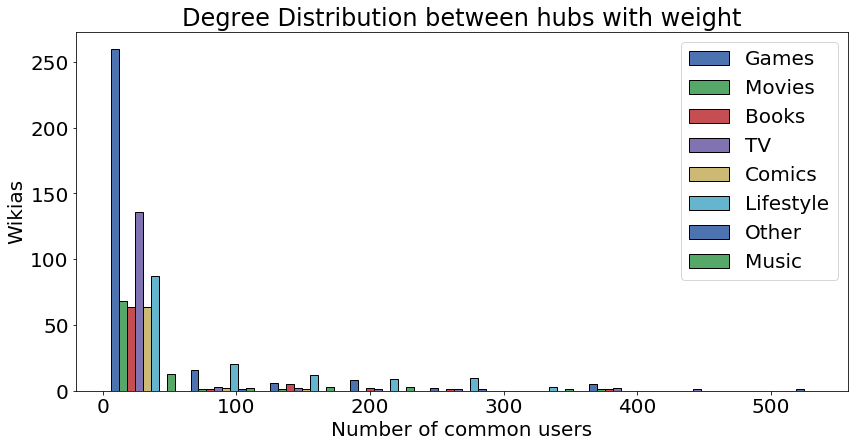

In [182]:
# Find degrees according to hub
hubsDegree = {}
maxDegree = 0
for i in range(len(G.nodes)): 
    n = list(G.nodes)[i]
    nodehubs = list(G.node[n]['hub'])
    degree = G.degree(n, weight='weight')
    for hub in nodehubs:
        if hub not in hubsDegree:
            hubsDegree[hub] = []
        hubsDegree[hub].append(degree)
    if degree>maxDegree:
        maxDegree = degree
    
# Create Bin Histogram 
plt.figure(figsize=(12, 6))  
plt.style.use('seaborn-deep')
bins = np.linspace(0, maxDegree, 10)

plt.hist(list(hubsDegree.values()), 
         bins, 
         label=list(hubsDegree.keys()), 
         histtype='bar',
         edgecolor='black')

plt.legend(loc='upper right')
plt.tight_layout()
plt.title("Degree Distribution between hubs with weight")
plt.ylabel("Wikias")
plt.xlabel("Number of common users")
plt.savefig('wikiDegreeWeightHist.png')
plt.show()

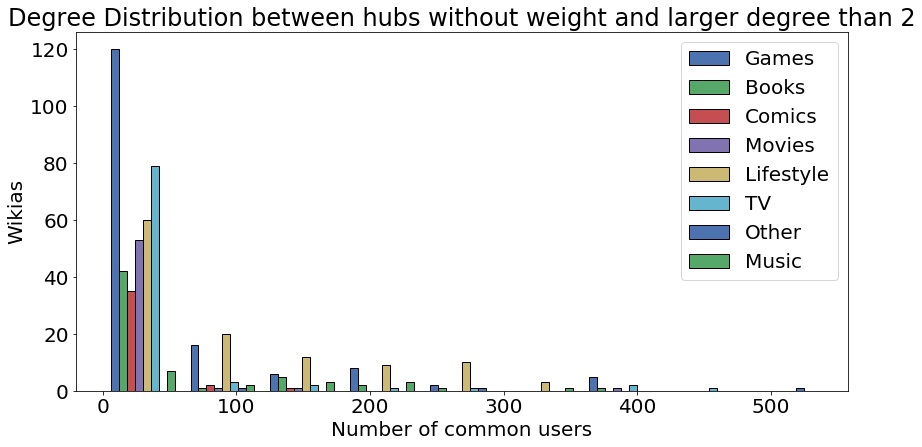

In [183]:
# Find degrees according to hub
hubsDegree = {}
maxDegree = 0
for i in range(len(G.nodes)): 
    n = list(G.nodes)[i]
    nodehubs = list(G.node[n]['hub'])
    degree = G.degree(n, weight='weight')
    if degree > 2:
        for hub in nodehubs:
            if hub not in hubsDegree:
                hubsDegree[hub] = []
            hubsDegree[hub].append(degree)
        if degree>maxDegree:
            maxDegree = degree
    
# Create Bin Histogram 
plt.figure(figsize=(12, 6))  
plt.style.use('seaborn-deep')
bins = np.linspace(0, maxDegree, 10)

plt.hist(list(hubsDegree.values()), 
         bins, 
         label=list(hubsDegree.keys()), 
         histtype='bar',
         edgecolor='black')

plt.legend(loc='upper right')
plt.tight_layout()
plt.title("Degree Distribution between hubs without weight and larger degree than 2")
plt.ylabel("Wikias")
plt.xlabel("Number of common users")
plt.savefig('wikiDegreelarger2WeightHist.png')
plt.show()

[(0, 148), (1, 89), (2, 59)]


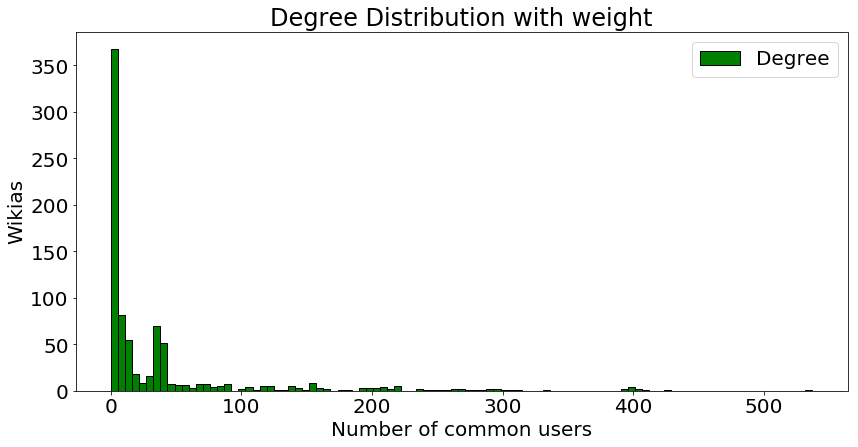

In [185]:
plt.rcParams.update({'font.size': 20})
degrees = [val for (node, val) in G.degree(weight='weight')]
cnt = collections.Counter(degrees)
print(cnt.most_common(3))
# Create Bin Histogram 
plt.figure(figsize=(12, 6))  
plt.style.use('seaborn-deep')
bins = np.linspace(0, max(degrees), 100)

plt.hist(degrees, 
         bins, 
         label="Degree", 
         histtype='bar',
         color='Green',
         edgecolor='black')

plt.legend(loc='upper right')
plt.tight_layout()
plt.title("Degree Distribution with weight")
plt.ylabel("Wikias")
plt.xlabel("Number of common users")
plt.savefig('wikiDegreeSumWeightHist.png')
plt.show()

[(2, 59), (42, 36), (37, 30)]


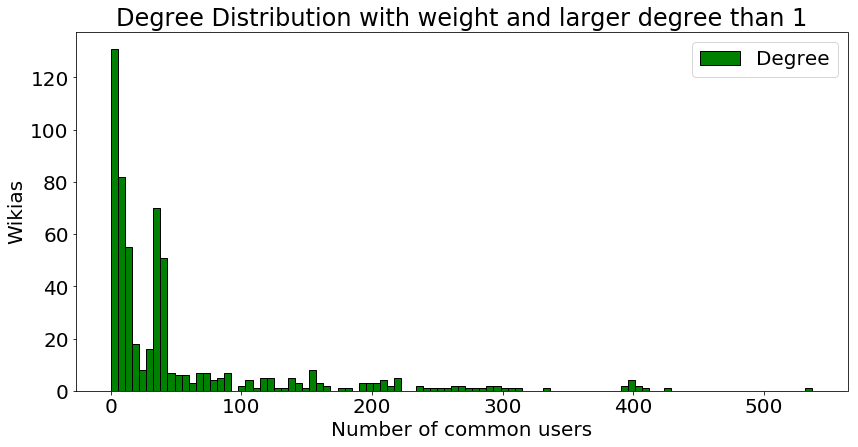

In [188]:
plt.rcParams.update({'font.size': 20})
degrees = [val for (node, val) in G.degree(weight='weight') if val>1]
cnt = collections.Counter(degrees)
print(cnt.most_common(3))
# Create Bin Histogram 
plt.figure(figsize=(12, 6))  
plt.style.use('seaborn-deep')
bins = np.linspace(0, max(degrees), 100)

plt.hist(degrees, 
         bins, 
         label="Degree", 
         histtype='bar',
         color='Green',
         edgecolor='black')

plt.legend(loc='upper right')
plt.tight_layout()
plt.title("Degree Distribution with weight and larger degree than 1")
plt.ylabel("Wikias")
plt.xlabel("Number of common users")
plt.savefig('wikiDegreeSumlarger1WeightHist.png')
plt.show()

In [195]:
# Data memory usage
sum(activeDataSet.memory_usage(index=False, deep=True))

1708604

TypeError: tuple indices must be integers or slices, not str